# Turbine check-out/calibration notebook (for Joukowski airfoil)

Use this notebook to set up a series of runs for turbine calibration and check-out

In [1]:
%%capture 

# Important header information
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import matplotlib.pyplot    as plt
import amrwind_frontend as amrwind
import tempfile
import shutil
# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

**Note**: Make sure there is a turbine file which looks like:

In [2]:
with open(amrwindfedir+"/turbines/GE1p68-82p5.yaml")as f: print(f.read())

turbines:
  Joukowski_GE1p68-82.5_calibLCC:
    turbinetype_name:    "NREL GE 1.68-82.5 Joukowski Calib"
    turbinetype_comment:         # Cp is stored in cp_table
    # See data in https://cee-gitlab.sandia.gov/wind/awaken/-/blob/master/TurbineCheckout/FLORIS_Turbine_Models/GE_1.68MW.yaml
    #cp_table: 0.358 0.35845500 0.41153273 0.41074811 0.40911105 0.40735054 0.40571029 0.40434534 0.40335535 0.40280379 0.40272377 0.40232212 0.40142065 0.40293169 0.40632635 0.40769739 0.40569587 0.39667887 0.37365321 0.36265005 0.28370014 0.22172972 0.17367047 0.13664976 0.10820611 0.08634229 0.06949084 0.05644616 0.04629447 0.03834599 0.03208054
    cp_table: 0.3016713057677416 0.39345186124735865 0.3932593872884728 0.3916920326945722 0.39000648367796215 0.3884360746578687 0.387129236715039 0.386181402329401 0.38565332474606967 0.38557671355846646 0.38519215792947603 0.38432907066672434 0.38861989389694285 0.4062033815759146 0.40357836305334926 0.37955694089972913 0.34474609939979 0.3062711419617

Note that both `Actuator_epsilon` and `Actuator_epsilon_tower` are commented out.  We can set those values later.

In [3]:
# Start the amrwind_frontend app 
case = amrwind.MyApp.init_nogui()

In [4]:
curdir=os.getcwd()

# Create a temporary working directory and switch to it

# Uncomment these lines to make your own tempdir
## tempdir = 'tempturbinedir'
## os.mkdir(tempdir)
# Otherwise use a system temporary directory
tempdir = tempfile.mkdtemp(prefix='tempturbine-')
os.chdir(tempdir)
print('Using temporary directory: '+tempdir)

Using temporary directory: /tmp/tempturbine-il34pkoh


## Set up the basic simulation properties

In [5]:
rhodensity = 1.225
WS         = 11.0                                     # This is temporary, we will vary across a range below
eps        = 5.0
vortex_core = 10.0
case.setAMRWindInput('useWSDir', True)
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)
case.setAMRWindInput('ABL_winddir', 270,  forcechange=True)
case.ABL_calculateWindVector()

In [6]:
case.setAMRWindInput('time_control',   ['const dt'])
case.setAMRWindInput('time.stop_time', 360)
case.setAMRWindInput('time.fixed_dt',  0.1)
case.setAMRWindInput('incflo.physics', ['FreeStream', 'Actuator'])

In [7]:
case.setAMRWindInput('ConstValue.density.value',  rhodensity)
case.setAMRWindInput('incflo.density',            rhodensity)
case.setAMRWindInput('incflo.velocity',           [WS, 0.0, 0.0])
case.setAMRWindInput('ConstValue.velocity.value', [WS, 0.0, 0.0])
case.setAMRWindInput('turbulence.model',          ['Laminar'])

## Set the BC's

In [8]:
case.setAMRWindInput('is_periodicx', False)
case.setAMRWindInput('is_periodicy', True)
case.setAMRWindInput('is_periodicz', True)  

case.setAMRWindInput('xlo.type', 'mass_inflow')
case.setAMRWindInput('xhi.type', 'pressure_outflow')
case.setAMRWindInput('xlo.density',  rhodensity)
case.setAMRWindInput('xlo.velocity', [WS, 0.0, 0.0])

In [9]:
# Add the turbine specifications flag
## Note that the options field can have things like:
##    ADparam_TwrAero:False ADparam_TwrShadow:0 FSTparam_TMax:181234.0
## To specify changes to the OpenFAST model
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0,     0, 0, NREL GE 1.68-82.5 Joukowski Calib, 270.0, 0.0, 
"""
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [10]:
case.setAMRWindInput('turbines_domainsize', [2560.0*2, 960.0*2, 960.0*2])
case.setAMRWindInput('turbines_backgroundmeshsize', 20.0)
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_freespace', True)   # Make this have no ground
#case.setAMRWindInput('zlo_type', 'slip_wall')
#case.setAMRWindInput('zhi_type', 'slip_wall')

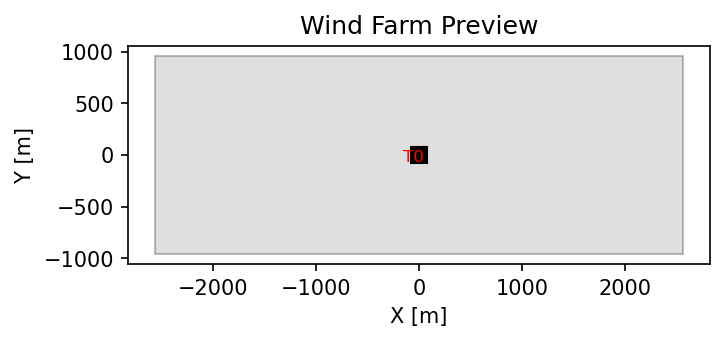

In [11]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [12]:
# Now create the turbines
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()
['T0']


In [13]:
# Set some globals
case.setAMRWindInput('Actuator_default_type', ['JoukowskyDisk'])
case.setAMRWindInput('Actuator_JoukowskyDisk_density',       rhodensity,      forcechange=True)
case.setAMRWindInput('Actuator_JoukowskyDisk_epsilon',       [eps, eps, eps], forcechange=True)  # You can change this
case.setAMRWindInput('Actuator_JoukowskyDisk_vortex_core_size', vortex_core, forcechange=True)  # You can change this

## Add turbine refinement

In [14]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     10,       10,         3,       2,     2,     center:farm
1,     2.5,      2.5,        2.5,     1.2,   1.2,   center:farm
2,     1,        1,          0.75,    0.8,   0.8,  
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [15]:
case.refine_createAllZones()
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['Farm_level_0_zone', 'Farm_level_1_zone', 'T0_level_2_zone']


Plotting turbines


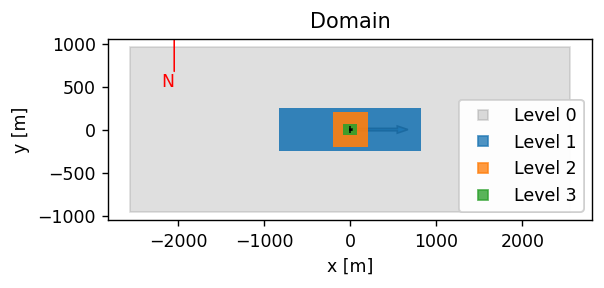

In [16]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax2)

Plotting turbines


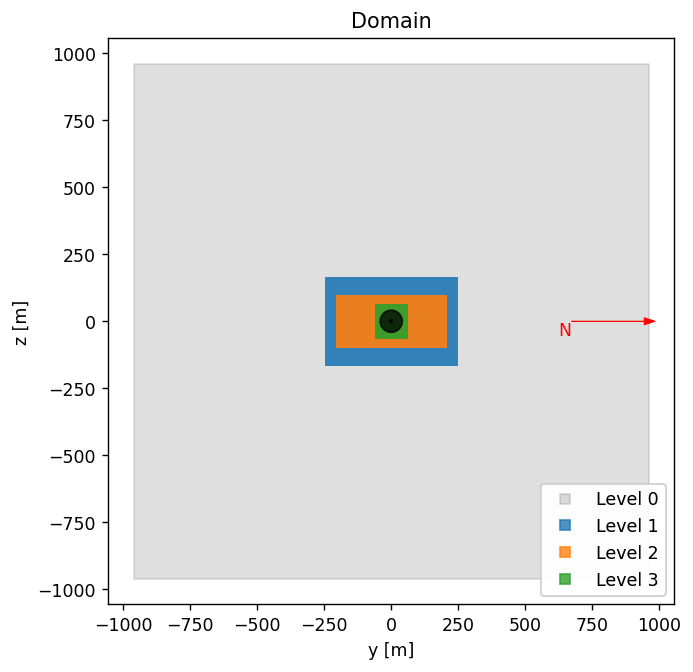

In [17]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

In [18]:
case.estimateMeshSize()

Refinement Farm_level_0_zone: level 1: 269527 cells
Refinement Farm_level_1_zone: level 2: 269527 cells
Refinement T0_level_2_zone: level 3: 172497 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0      2359296             20.0 x 20.0 x 20.0
       1       269527             10.0 x 10.0 x 10.0
       2       269527                5.0 x 5.0 x 5.0
       3       172497                2.5 x 2.5 x 2.5
  TOTAL:      3070847


### Create sampling planes

In [19]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
hh,  hubheight,2560,2560,960, 0,  none,  11, 11, usedx:10 units:meter center:farm orientation:x
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [20]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_hh']


Plotting turbines


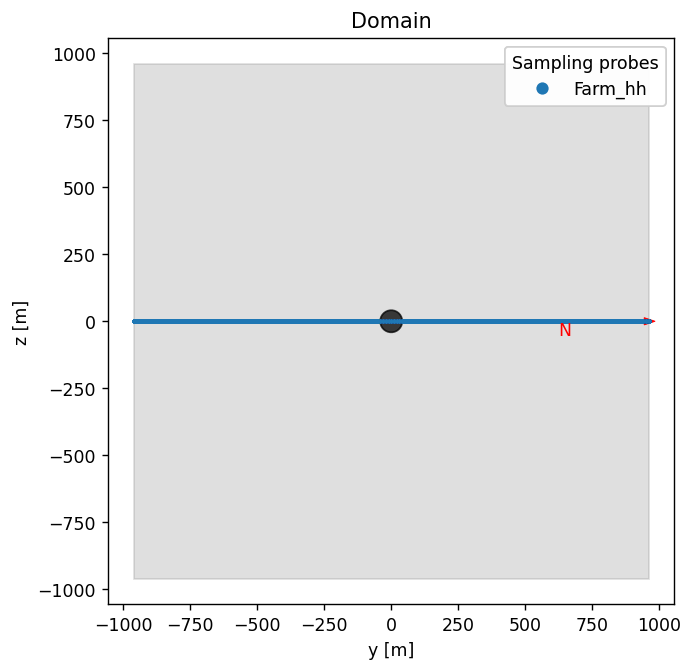

In [21]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

In [22]:
print(case.writeAMRWindInput(''))

# --- Simulation time control parameters ---
time.stop_time                           = 360.0               # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
incflo.physics                           = FreeStream Actuator # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = Laminar             
incflo.gravity                           = 0.0 0.0 -9.81       # Gravitational acceleration vector (x,y,z) [m/s^2]
incflo.density                           = 1.225               # Fluid density [kg/m^3]
transport.viscosity 

In [23]:
# Clean up the temporary directory
docleanup = True
os.chdir(curdir)
if docleanup:
    try:
        shutil.rmtree(tempdir)
    except:
        print("Error cleaning up: "+tempdir)

## Set up a wind sweep

In [24]:
# Set the parameters
case.setAMRWindInput('sweep_windspeeds', '7 9 10 11 13')
case.setAMRWindInput('sweep_winddirs',   '270')
case.setAMRWindInput('sweep_caseprefix', 'Calibrate_Joukowski_C{CASENUM}_EPS%0.2f_VC%0.2f_WS_{WS}'%(eps, vortex_core))
case.setAMRWindInput('sweep_dirprefix',  'Calibrate_Joukowski_C{CASENUM}_EPS%0.2f_VC%0.2f_WS_{WS}'%(eps, vortex_core))
case.setAMRWindInput('sweep_usenewdirs', True)
case.setAMRWindInput('sweep_logfile',    'RunCalibration_Joukowski_EPS%0.2f_VC%0.2f_newcurves_logfile.yaml'%(eps, vortex_core))

In [25]:
# Submission parameters
case.popup_storteddata['submitscript']['submitscript_numnodes'] = 4
case.popup_storteddata['submitscript']['submitscript_runtime']  = '4:00:00'
case.popup_storteddata['submitscript']['submitscript_wcid']     = 'fy210193'
case.popup_storteddata['submitscript']['submitscript_partition']= 'short,batch'
case.popup_storteddata['submitscript']['submitscript_corespernode'] = 36
case.popup_storteddata['submitscript']['submitscript_queue']    = 'normal'
case.popup_storteddata['submitscript']['submitscript_jobname']  = 'GE1p68'
case.popup_storteddata['submitscript']['submitscript_exe']      = '/projects/wind_uq/lcheung/AMRWindBuilds/awaken.20221207/amr-wind/build/amr_wind'

case.setAMRWindInput('sweep_createsubmitscript', True)
case.setAMRWindInput('sweep_submitjob',          False)

In [26]:
# Set up the cases
case.sweep_SetupRunParamSweep(verbose=True)

       NUM           WS         WDir            Case name
       ---           --         ----            ---------
         0      7.00000    270.00000 Calibrate_Joukowski_C0_EPS5.00_VC10.00_WS_7.0
Saved Calibrate_Joukowski_C0_EPS5.00_VC10.00_WS_7.0.sh
         1      9.00000    270.00000 Calibrate_Joukowski_C1_EPS5.00_VC10.00_WS_9.0
Saved Calibrate_Joukowski_C1_EPS5.00_VC10.00_WS_9.0.sh
         2     10.00000    270.00000 Calibrate_Joukowski_C2_EPS5.00_VC10.00_WS_10.0
Saved Calibrate_Joukowski_C2_EPS5.00_VC10.00_WS_10.0.sh
         3     11.00000    270.00000 Calibrate_Joukowski_C3_EPS5.00_VC10.00_WS_11.0
Saved Calibrate_Joukowski_C3_EPS5.00_VC10.00_WS_11.0.sh
         4     13.00000    270.00000 Calibrate_Joukowski_C4_EPS5.00_VC10.00_WS_13.0
Saved Calibrate_Joukowski_C4_EPS5.00_VC10.00_WS_13.0.sh


### Save the calibration

In [27]:
# Save the wind farm setup
case.setAMRWindInput('farm_usercomments', 'Test calibration process.')
case.writeFarmSetupYAML('TurbineCalibrateGE1p68_Joukowski_EPS%0.2f_VC%0.2f_newcurves.yaml'%(eps, vortex_core))

Saved farm setup to TurbineCalibrateGE1p68_Joukowski_EPS5.00_VC10.00_newcurves.yaml
